In [1]:
'''
folder = str("../logs/20200829_11_53_21/") # 1D no Noise yesPeriodic no Rot - d.keepData(0,91500)
folder = str("../logs/20200829_12_05_54/") # 1D yesNoise yesPeriodic no Rot
folder = str("../logs/20200829_12_14_39/") # 1D no Noise no Periodic no Rot
folder = str("../logs/20200829_12_22_54/") # 1D yesNoise no Periodic no Rot
folder = str("../logs/20200829_12_37_57/") # 1D no Noise yesPeriodic yesRot
folder = str("../logs/20200829_12_50_33/") # 1D yesNoise yesPeriodic yesRot
folder = str("../logs/20200829_12_58_43/") # 1D no Noise no Periodic yesRot
folder = str("../logs/20200829_13_07_41/") # 1D yesNoise no Periodic yesRot
folder = str("../logs/20200829_15_02_13/") # 2D no Noise yesPeriodic no Rot
folder = str("../logs/20200829_15_14_20/") # 2D yesNoise yesPeriodic no Rot
folder = str("../logs/20200829_15_24_14/") # 2D no Noise no Periodic no Rot
folder = str("../logs/20200829_15_35_38/") # 2D yesNoise no Periodic no Rot
folder = str("../logs/20200829_16_11_21/") # 2D no Noise yesPeriodic yesRot
folder = str("../logs/20200829_16_25_41/") # 2D yesNoise yesPeriodic yesRot
folder = str("../logs/20200829_16_39_47/") # 2D yesNoise no Periodic yesRot
folder = str("../logs/20200829_16_48_48/") # 2D no Noise no Periodic yesRot



folder = str("../logs/20201002_10_16_28/") # Y up Stand still 
folder = str("../logs/20201002_10_17_42/") # Y up Calib for Magneto
folder = str("../logs/20201002_10_19_33/") # Y up Test
folder = str("../logs/20201002_11_03_27/") # Z up Stand still
folder = str("../logs/20201002_11_03_37/") # Z up Calib for Magneto
folder = str("../logs/20201002_11_04_35/") # Z up Test
folder = str("../logs/20201002_11_05_25/") # Z up Training 
folder = str("../logs/20201002_11_07_24/") # Y up Training
''';

In [2]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from DataStreamPreprocessor import DataStream
from Quaternion_functions import w_flip, w_back_flip, MOC_to_MAD, MAD_to_MOC, transform, turn, distance_check, mocap_correction
import matplotlib.pyplot
import tensorflow as tf
import time
from pyquaternion import Quaternion

tf.random.set_seed(42) 
np.random.seed(42)

from ahrs.utils import WMM
from ahrs.utils import WGS
import ahrs

In [79]:
#folder = str("../logs/20201002_10_16_28/") # Y up - Stand still
folder_calib = str("../logs/20201002_10_17_42/")  # Y up - Calib for Magneto
folder_test  = str("../logs/20201002_10_19_33/")  # Y up - General Test

folder_test = str("../logs/20200829_12_37_57/") # 2D yesNoise no Periodic yesRot
#folder_test = str("../logs/20200829_12_05_54/") # 1D yesNoise yesPeriodic no Rot
#folder_test = str("../logs/20201002_10_17_42/") # Y up Calib for Magneto
#file = str("../logs/20201002_11_07_24/") # Y up - Training data

d = DataStream(folder_test)
c = DataStream(folder_calib)

d.calibrateMag(c)

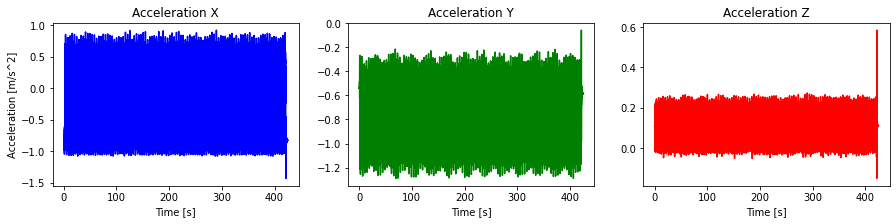

In [80]:
d.plotData(acc=True)

In [81]:
print('d.data shape: ' + str(d.data.shape))
d.showHeader()

d.filterData(31, 'hanning', [1, 2, 3]) # filter Acc
d.filterData(31, 'hanning', [4, 5, 6]) # filter Gyro
d.filterData(31, 'hanning', [7, 8, 9]) # filter Mag
#d.plotData(acc=True,gyro=True,mag=True)

Acc    = d.data[:,1:4]
Gyro   = d.data[:,4:7]
Mag    = d.data[:,7:10]
MocapQ = d.data[:,13:17]
MocapE = d.data[:,17:20]

d.data shape: (105941, 20)
0 - Timestamp
1 - AccX
2 - AccY
3 - AccZ
4 - GyroX
5 - GyroY
6 - GyroZ
7 - MagX
8 - MagY
9 - MagZ
10 - Marg_posX
11 - Marg_posY
12 - Marg_posZ
13 - Marg_quatW
14 - Marg_quatX
15 - Marg_quatY
16 - Marg_quatZ
17 - Marg_rotX
18 - Marg_rotY
19 - Marg_rotZ


In [100]:
MadgwickQ = ahrs.filters.Madgwick(acc=Acc*9.8077, gyr=Gyro/57.3, mag=Mag*10, gain=0.041, Dt=0.004) #q0=q_init #az itteni beszorzások nekem segítettek az eredményekkel
print('MadgwickQ shape: ' + str(MadgwickQ.Q.shape))                        #gain = 0.000001



MadgwickQ shape: (105941, 4)


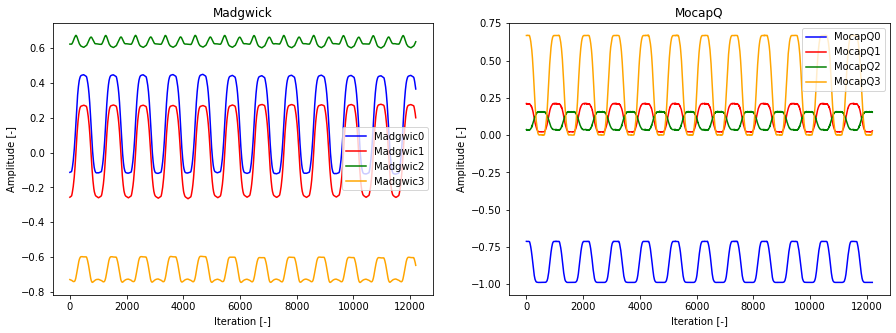

In [103]:
start = 24000
end = 36200

plt.figure(3, figsize=(15, 5))
plt.subplot(121)
plt.title("Madgwick")
plt.plot(MadgwickQ.Q[start:end,0], color='blue', label='Madgwic0')
plt.plot(MadgwickQ.Q[start:end,1], color='red', label='Madgwic1')
plt.plot(MadgwickQ.Q[start:end,2], color='green', label='Madgwic2')
plt.plot(MadgwickQ.Q[start:end,3], color='orange', label='Madgwic3')
plt.xlabel('Iteration [-]')
plt.ylabel('Amplitude [-]')
plt.legend()

plt.subplot(122)
plt.title("MocapQ")
plt.plot(MocapQ[start:end,0], color='blue', label='MocapQ0')
#plt.plot(MadgwickQ.Q[start:end,0], color='blue', label='Madgwic0')
plt.plot(MocapQ[start:end,1], color='red', label='MocapQ1')
plt.plot(MocapQ[start:end,2], color='green', label='MocapQ2')
plt.plot(MocapQ[start:end,3], color='orange', label='MocapQ3')
plt.xlabel('Iteration [-]')
plt.ylabel('Amplitude [-]')
plt.legend()
plt.show()

plt.show()

In [59]:
import math
def findw(quat):
    c = 0
    loss = 1
    for i in range(4):
        #print(quat[0], quat[1], quat[2], quat[3])
        w = quat[i]
        #print(w)
        alfa = math.acos(w)
        x = quat[(i+1)%4] / math.sin(alfa)
        #print(quat[(i+1)%4])
        y = quat[(i+2)%4] / math.sin(alfa)
        #print(quat[(i+2)%4])
        z = quat[(i+3)%4] / math.sin(alfa)
        #print(quat[(i+3)%4])
        
        
        summ = x**2 + y**2 + z**2
        print('summ:',summ)
        if (abs(1-summ)<loss):
            loss = abs(1-summ)
            c = i
    print('c:',c,'loss:', loss)
    return c, loss
        
    

In [60]:
c, loss = findw(MadgwickQ.Q[5000])

summ: 1.0000000000000004
summ: 1.0000000000000002
summ: 1.0000000000000004
summ: 1.0000000000000002
c: 1 loss: 2.220446049250313e-16


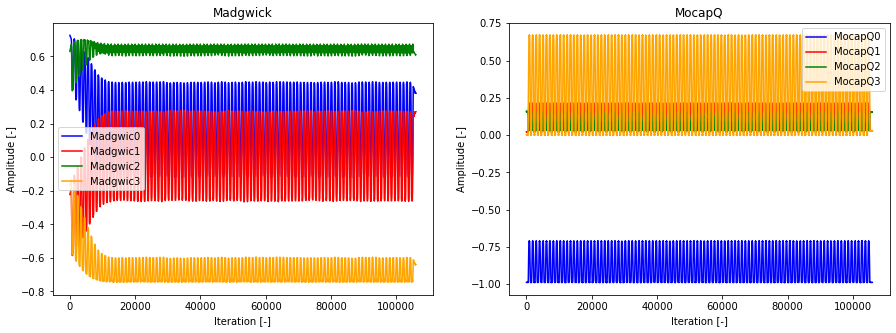

In [102]:


plt.figure(3, figsize=(15, 5))
plt.subplot(121)
plt.title("Madgwick")
plt.plot(MadgwickQ.Q[:,0], color='blue', label='Madgwic0')
plt.plot(MadgwickQ.Q[:,1], color='red', label='Madgwic1')
plt.plot(MadgwickQ.Q[:,2], color='green', label='Madgwic2')
plt.plot(MadgwickQ.Q[:,3], color='orange', label='Madgwic3')
plt.xlabel('Iteration [-]')
plt.ylabel('Amplitude [-]')
plt.legend()

plt.subplot(122)
plt.title("MocapQ")
plt.plot(MocapQ[:,0], color='blue', label='MocapQ0')
plt.plot(MocapQ[:,1], color='red', label='MocapQ1')
plt.plot(MocapQ[:,2], color='green', label='MocapQ2')
plt.plot(MocapQ[:,3], color='orange', label='MocapQ3')
plt.xlabel('Iteration [-]')
plt.ylabel('Amplitude [-]')
plt.legend()
plt.show()

plt.show()

In [62]:
def qprod(a, b):
    '''Quaternion multiplication.'''
    w=a[0]*b[0]-a[1]*b[1]-a[2]*b[2]-a[3]*b[3]
    x=a[0]*b[1]+a[1]*b[0]+a[2]*b[3]-a[3]*b[2]
    y=a[0]*b[2]+a[2]*b[0]-a[1]*b[3]+a[3]*b[1]
    z=a[0]*b[3]+a[3]*b[0]+a[1]*b[2]-a[2]*b[1]
    q=[]
    q.append(w)
    q.append(x)
    q.append(y)
    q.append(z)

    return q

def invq(a):
    w = a[0]
    x = a[1]* -1
    y = a[2]* -1
    z = a[3]* -1
    q = np.zeros(4)
    q[0] = w
    q[1] = x
    q[2] = y
    q[3] = z
    
    return q
    

In [63]:
print(MadgwickQ.Q[0])
print(invq(MadgwickQ.Q[0]))
print(len(MadgwickQ.Q))

[ 0.72552605 -0.22310751  0.62984904 -0.16469725]
[ 0.72552605  0.22310751 -0.62984904  0.16469725]
92243


In [86]:
#MadgwickQ.Q = w_flip(MadgwickQ.Q)
print(MadgwickQ.Q[0])
mad = MadgwickQ.Q[15000]
moc = MocapQ[15000]

mad = invq(mad)
moc = invq(moc)


MadgwickQ.Q_rel = np.zeros((len(MadgwickQ.Q),4))
MocapQ_rel = np.zeros((len(MocapQ),4))

print(MadgwickQ.Q[0])

for i in range(len(MadgwickQ.Q)):
    MadgwickQ.Q_rel[i] = qprod(MadgwickQ.Q[i],mad)
    MocapQ_rel[i] = qprod(MocapQ[i],moc)
    
print(MadgwickQ.Q[0])



[ 0.72284335 -0.21773033  0.63551328 -0.16190696]
[ 0.72284335 -0.21773033  0.63551328 -0.16190696]
[ 0.72284335 -0.21773033  0.63551328 -0.16190696]


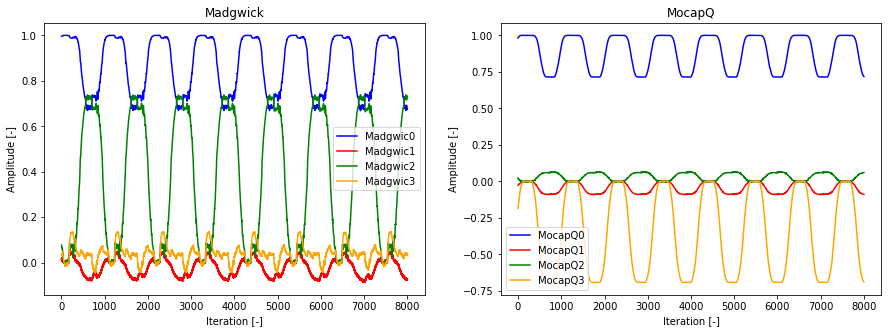

summ: 1.0
summ: 0.9999999999999998
summ: 0.9999999999999999
summ: 1.0000000000000002
c: 0 loss: 0.0


In [87]:
start = 18000
end = 26000

plt.figure(3, figsize=(15, 5))
plt.subplot(121)
plt.title("Madgwick")
plt.plot(MadgwickQ.Q_rel[start:end,0], color='blue', label='Madgwic0')
plt.plot(MadgwickQ.Q_rel[start:end,1], color='red', label='Madgwic1')
plt.plot(MadgwickQ.Q_rel[start:end,2], color='green', label='Madgwic2')
plt.plot(MadgwickQ.Q_rel[start:end,3], color='orange', label='Madgwic3')
plt.xlabel('Iteration [-]')
plt.ylabel('Amplitude [-]')
plt.legend()

plt.subplot(122)
plt.title("MocapQ")
plt.plot(MocapQ_rel[start:end,0], color='blue', label='MocapQ0')
plt.plot(MocapQ_rel[start:end,1], color='red', label='MocapQ1')
plt.plot(MocapQ_rel[start:end,2], color='green', label='MocapQ2')
plt.plot(MocapQ_rel[start:end,3], color='orange', label='MocapQ3')
plt.xlabel('Iteration [-]')
plt.ylabel('Amplitude [-]')
plt.legend()
plt.show()

plt.show()

c, loss = findw(MadgwickQ.Q_rel[0])

In [17]:
print(MadgwickQ.Q[750])
print(MocapQ[750])

[ 0.34414498 -0.55172051  0.44835035 -0.61331124]
[-0.72805995  0.20718399  0.04089513  0.65217316]


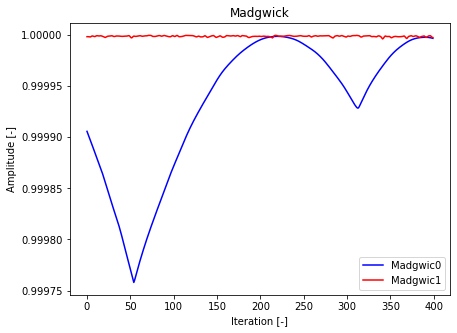

In [68]:
plt.figure(3, figsize=(15, 5))
plt.subplot(121)
plt.title("Madgwick")
plt.plot(MadgwickQ.Q_rel[21000:21400,0], color='blue', label='Madgwic0')
plt.plot(MocapQ_rel[21000:21400,0], color='red', label='Madgwic1')

plt.xlabel('Iteration [-]')
plt.ylabel('Amplitude [-]')
plt.legend()

In [52]:
import sympy
import math


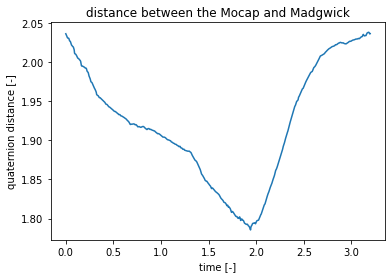

In [19]:
distance = distance_check(MadgwickQ.Q[14800:15600], MocapQ[14800:15600], dlist=True)

In [77]:
#for i in range(17000):
 #   print(i, distance[i])

In [ ]:
#for i in range(len(MocapQ)):
 #   print(i, MocapQ[i,0])

In [88]:
#855, 1775, 2645
#4500, 5000, 5500 (0.1-nél)
from Quaternion_functions import qprod

f = 21000
s = 21500
t = 22300

mad1 = MadgwickQ.Q_rel[f,1:]
mad2 = MadgwickQ.Q_rel[s,1:]
mad3 = MadgwickQ.Q_rel[t,1:]

#mad1[3] = mad1[3]* -1
#mad2[3] = mad2[3]* -1
#mad3[3] = mad3[3]* -1

moc1 = MocapQ_rel[f,1:]
moc2 = MocapQ_rel[s,1:]
moc3 = MocapQ_rel[t,1:]

#mad = qprod( qprod(mad1, mad2), mad3)
#moc = qprod( qprod(moc1, moc2), moc3)

print(mad)
print(moc)
moc = [moc,moc]
mad = [mad, mad]

[ 0.38237687 -0.34036649 -0.55167719  0.65847616]
[-0.98751712 -0.02245466 -0.1558968  -0.00137247]


In [89]:
print(mad1)
print(mad2)
print(mad3)

print(moc1)
print(moc2)
print(moc3)

[-0.05088483  0.59343939  0.05654488]
[0.01156555 0.11097324 0.06136195]
[ 0.00393201  0.00319615 -0.01438166]
[-0.08148597  0.06030229 -0.64583525]
[-0.00310757  0.00225822 -0.02221288]
[-0.00191879  0.00129714 -0.01277575]


In [90]:
#sol = transform(moc, mad,'MOC',1)

In [91]:
import sympy

a = sympy.Symbol('a')
b = sympy.Symbol('b')
c = sympy.Symbol('c')
d = sympy.Symbol('d')
e = sympy.Symbol('e')
f = sympy.Symbol('f')
g = sympy.Symbol('g')
h = sympy.Symbol('h')
i = sympy.Symbol('i')

#[a,b,c
# d,e,f
# g,h,i]

eq1 = mad1[0] * a + mad1[1] * b + mad1[2] * c - moc1[0]
eq2 = mad1[0] * d + mad1[1] * e + mad1[2] * f - moc1[1]
eq3 = mad1[0] * g + mad1[1] * h + mad1[2] * i - moc1[2]

eq4 = mad2[0] * a + mad2[1] * b + mad2[2] * c - moc2[0]
eq5 = mad2[0] * d + mad2[1] * e + mad2[2] * f - moc2[1]
eq6 = mad2[0] * g + mad2[1] * h + mad2[2] * i - moc2[2]

eq7 = mad3[0] * a + mad3[1] * b + mad3[2] * c - moc3[0]
eq8 = mad3[0] * d + mad3[1] * e + mad3[2] * f - moc3[1]
eq9 = mad3[0] * g + mad3[1] * h + mad3[2] * i - moc3[2]



sol=(sympy.nsolve((eq1,eq2,eq3,eq4,eq5,eq6,eq7,eq8,eq9), (a,b,c,d,e,f,g,h,i),(0,0,0,0,0,0,0,0,0),verify=False))
print(sol)


Matrix([[0.196832145756011], [-0.135406806629099], [0.157141256609374], [-0.158748530825851], [0.0986436490447651], [-0.111674597448312], [1.86394669626702], [-1.03965255953266], [1.16689843512228]])


In [92]:
solution = np.array([[sol[0], sol[1], sol[2]], [sol[3], sol[4], sol[5]], [sol[6], sol[7], sol[8]]])
print(solution)
print(np.matmul(solution, [[0],[0],[1]]))

[[0.196832145756011 -0.135406806629099 0.157141256609374]
 [-0.158748530825851 0.0986436490447651 -0.111674597448312]
 [1.86394669626702 -1.03965255953266 1.16689843512228]]
[[0.157141256609374]
 [-0.111674597448312]
 [1.16689843512228]]


In [93]:
for i in range(len(MadgwickQ.Q_rel)):
    MadgwickQ.Q_rel[i, 1:] = np.matmul(solution, MadgwickQ.Q_rel[i, 1:])

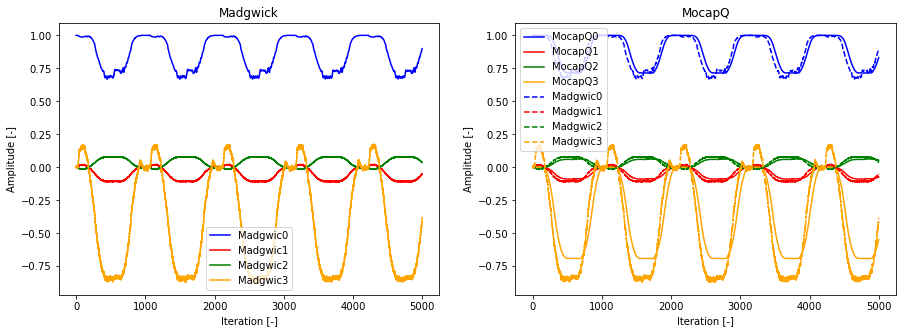

In [95]:
start = 15000
end = 20000

plt.figure(3, figsize=(15, 5))
plt.subplot(121)
plt.title("Madgwick")
plt.plot(MadgwickQ.Q_rel[start:end,0], color='blue', label='Madgwic0')
plt.plot(MadgwickQ.Q_rel[start:end,1], color='red', label='Madgwic1')
plt.plot(MadgwickQ.Q_rel[start:end,2], color='green', label='Madgwic2')
plt.plot(MadgwickQ.Q_rel[start:end,3], color='orange', label='Madgwic3')
plt.xlabel('Iteration [-]')
plt.ylabel('Amplitude [-]')
plt.legend()

plt.subplot(122)
plt.title("MocapQ")
plt.plot(MocapQ_rel[start:end,0], color='blue', label='MocapQ0')
plt.plot(MocapQ_rel[start:end,1], color='red', label='MocapQ1')
plt.plot(MocapQ_rel[start:end,2], color='green', label='MocapQ2')
plt.plot(MocapQ_rel[start:end,3], color='orange', label='MocapQ3')
plt.plot(MadgwickQ.Q_rel[start:end,0], color='blue', label='Madgwic0',linestyle= '--')
plt.plot(MadgwickQ.Q_rel[start:end,1], color='red', label='Madgwic1',linestyle='--')
plt.plot(MadgwickQ.Q_rel[start:end,2], color='green', label='Madgwic2',linestyle= '--')
plt.plot(MadgwickQ.Q_rel[start:end,3], color='orange', label='Madgwic3',linestyle= '--')
plt.xlabel('Iteration [-]')
plt.ylabel('Amplitude [-]')
plt.legend()
plt.show()

plt.show()

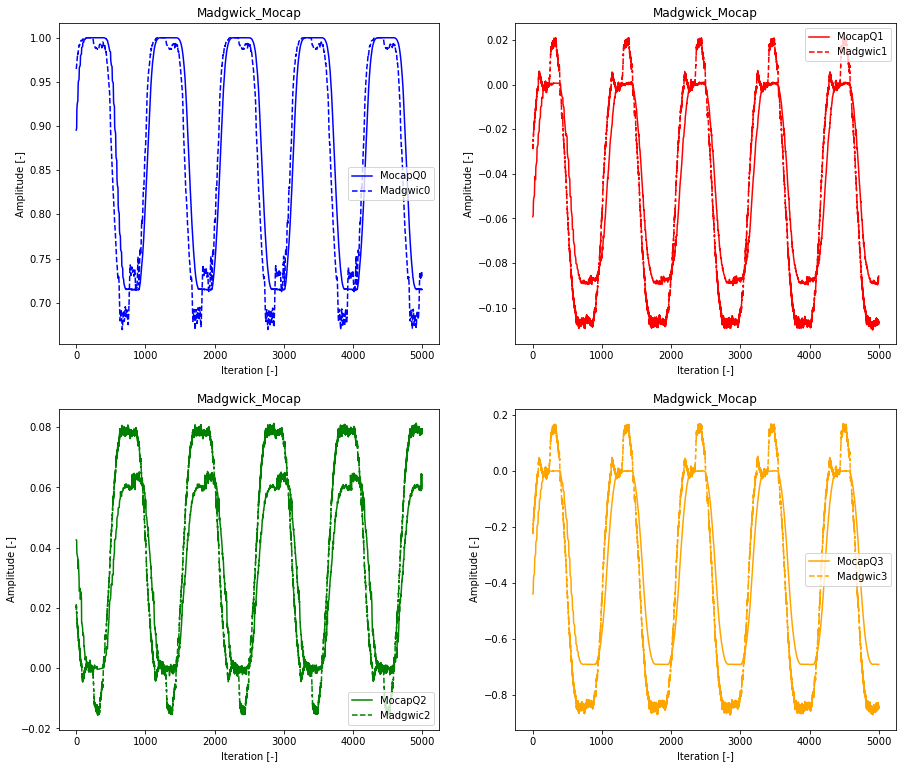

In [97]:
start = 40000
end = 45000

plt.figure(3, figsize=(15, 13))
plt.subplot(221)
plt.title("Madgwick_Mocap")
plt.plot(MocapQ_rel[start:end,0], color='blue', label='MocapQ0')
plt.plot(MadgwickQ.Q_rel[start:end,0], color='blue', label='Madgwic0',linestyle= '--')
plt.xlabel('Iteration [-]')
plt.ylabel('Amplitude [-]')
plt.legend()

plt.subplot(222)
plt.title("Madgwick_Mocap")
plt.plot(MocapQ_rel[start:end,1], color='red', label='MocapQ1')
plt.plot(MadgwickQ.Q_rel[start:end,1], color='red', label='Madgwic1',linestyle='--')
plt.xlabel('Iteration [-]')
plt.ylabel('Amplitude [-]')
plt.legend()

plt.subplot(223)
plt.title("Madgwick_Mocap")
plt.plot(MocapQ_rel[start:end,2], color='green', label='MocapQ2')
plt.plot(MadgwickQ.Q_rel[start:end,2], color='green', label='Madgwic2',linestyle= '--')
plt.xlabel('Iteration [-]')
plt.ylabel('Amplitude [-]')
plt.legend()

plt.subplot(224)
plt.title("Madgwick_Mocap")
plt.plot(MocapQ_rel[start:end,3], color='orange', label='MocapQ3')
plt.plot(MadgwickQ.Q_rel[start:end,3], color='orange', label='Madgwic3',linestyle= '--')
plt.xlabel('Iteration [-]')
plt.ylabel('Amplitude [-]')
plt.legend()


plt.show()

plt.show()